# Student's-t distribution

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, t
from numpy.random import seed
import seaborn as sns

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (8, 4)

In [3]:
apikey = os.environ["AVANTAGE_API"]

In [4]:
# https://www.alphavantage.co/documentation/
url = "https://www.alphavantage.co/query"
symbol = "TSLA"
params = {
    "function": "TIME_SERIES_DAILY_ADJUSTED",
    "symbol": symbol,
    "outputsize": "full",
    "apikey": apikey
}

r = requests.get(url, params=params)
r

<Response [200]>

In [5]:
stock = pd.DataFrame.from_dict(r.json()["Time Series (Daily)"], orient="index", dtype=float)
stock.index = pd.to_datetime(stock.index)
stock = stock.sort_index()
stock_ret = stock.rename({"5. adjusted close": symbol}, axis=1)[symbol].pct_change().dropna()
N = len(stock_ret)

### Fitting a normal distribution to `TSLAs` returns

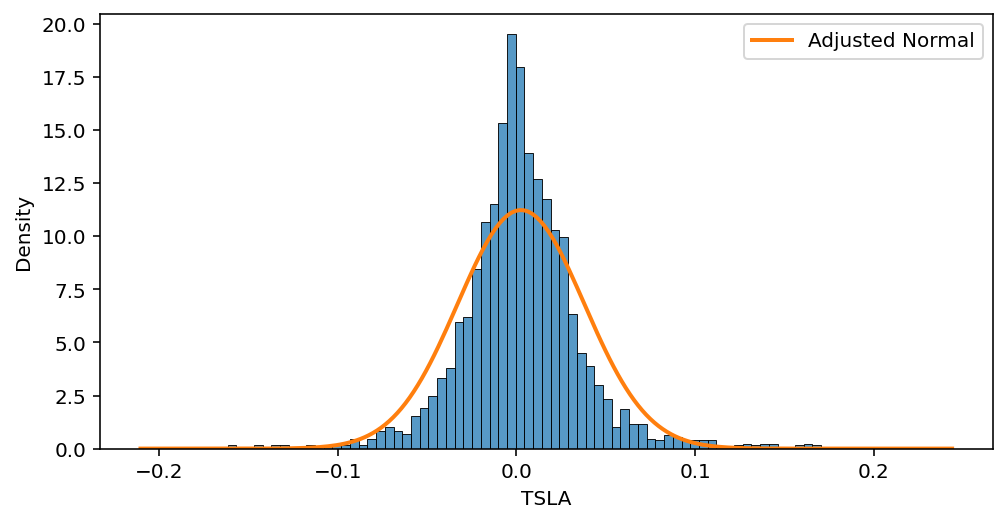

In [15]:
mu, sigma = stock_ret.mean(), stock_ret.std(ddof=1)
N_stock = norm(loc=mu, scale=sigma)

xrange = np.linspace(stock_ret.min(), stock_ret.max(), 200)
sns.histplot(stock_ret, stat="density");
plt.plot(xrange, N_stock.pdf(xrange), label="Adjusted Normal", c="tab:orange", linewidth=2)
plt.legend()
plt.savefig("fitted-norm-dist.png", dpi=100)

## The data-generating process

In [7]:
def generate_process(μ, a, b, timesteps):
    G = gamma(a=a, scale=b)
    sigmas = G.rvs(timesteps)
    returns = norm(loc=μ, scale=sigmas).rvs()
    
    return returns, sigmas

In [8]:
seed(31415)
n_timesteps = 50
μ, a, b = 0.7, 1, 10
returns, sigmas = generate_process(μ, a, b, n_timesteps)
timesteps = np.arange(n_timesteps)

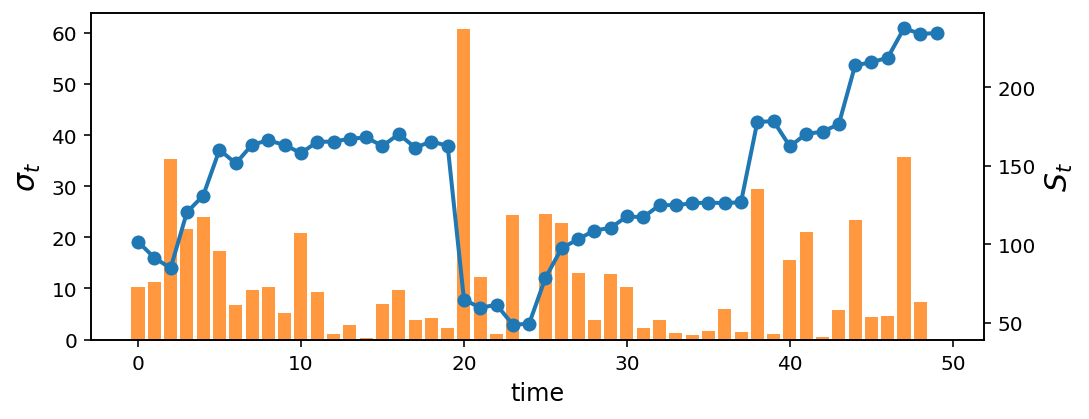

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
ax2.plot(100 + returns.cumsum(), linewidth=2, marker="o")
ax.bar(timesteps, sigmas, color="tab:orange", alpha=0.8)
ax.set_ylabel(r"$\sigma_t$", fontsize=15)
ax2.set_ylabel(r"$S_t$", fontsize=15)
ax.set_xlabel("time", fontsize=12);
#plt.savefig("/Users/gerardoduran/Desktop/process.png", dpi=150)

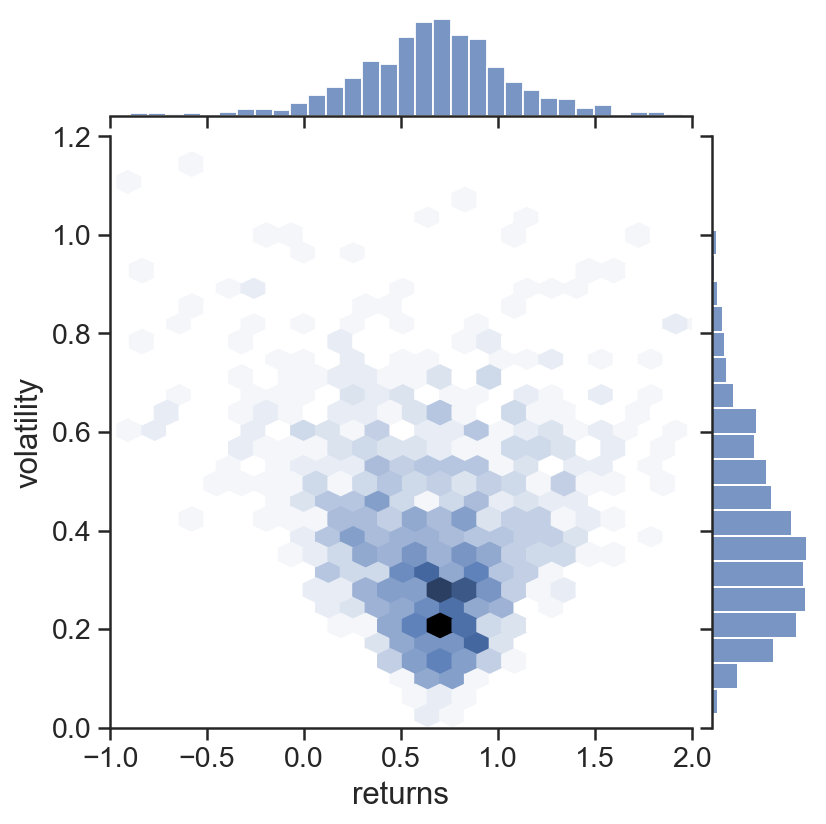

In [50]:
seed(31415)
n_timesteps = 1_000
μ, a, b = 0.7, 4, 0.1
returns, sigmas = generate_process(μ, a, b, n_timesteps)

data = pd.DataFrame({
    "volatility": sigmas,
    "returns": returns
})


sns.set(font_scale=1.3, style="ticks")
sns.jointplot(data=data, x="returns", y="volatility", kind="hex", ylim=(0, 1.2), xlim=(-1, 2))
# plt.savefig("/Users/gerardoduran/Desktop/joint-normal-gamma.png", dpi=100)º

## Fitting a student's-t

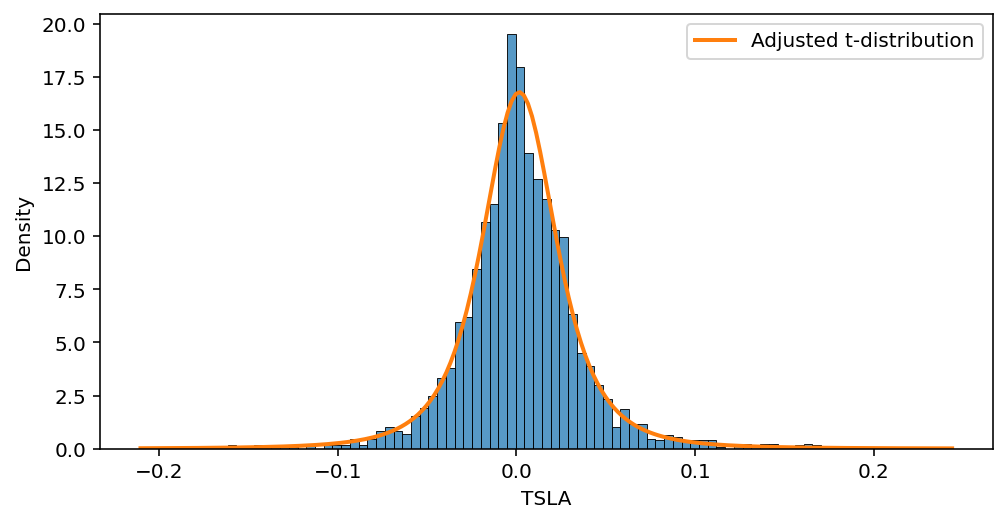

In [9]:
t_stock = t(*t.fit(stock_ret))

xrange = np.linspace(stock_ret.min(), stock_ret.max(), 200)
sns.histplot(stock_ret, kde=False, stat="density");
plt.plot(xrange, t_stock.pdf(xrange), label="Adjusted t-distribution", c="tab:orange", linewidth=2)
plt.legend()
plt.savefig("fitted-t-dist.png", dpi=100)

In [10]:
!open .